# Problema do Carteiro Chinês Capacitado

Gerar dados do problema


In [1]:
using Pkg
pkg"activate ."
pkg"add JuMP"
pkg"add Interact"
ENV["GUROBI_HOME"] = "/home/franklin/Documentos/gurobi/gurobi903/linux64"
pkg"add Gurobi" 
pkg"add Plots"
pkg"add Random"
pkg"add Juniper"
pkg"add Ipopt"
#pkg"add Cbc"
#pkg"add Clp"

 Activating environment at `~/Documentos/Projeto 1 - PCC/Project.toml`
   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


    Fetching: [

Fetching: [========================================>]  100.0 %                    ]  47.6 %Fetching: [=======================>                 ]  56.4 %>         ]  77.3 %

  Resolving package versions...
   Updating `~/Documentos/Projeto 1 - PCC/Project.toml`
 [no changes]
   Updating `~/Documentos/Projeto 1 - PCC/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Documentos/Projeto 1 - PCC/Project.toml`
 [no changes]
   Updating `~/Documentos/Projeto 1 - PCC/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Documentos/Projeto 1 - PCC/Project.toml`
 [no changes]
   Updating `~/Documentos/Projeto 1 - PCC/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Documentos/Projeto 1 - PCC/Project.toml`
 [no changes]
   Updating `~/Documentos/Projeto 1 - PCC/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Documentos/Projeto 1 - PCC/Project.toml`
 [no changes]
   Updating `~/Documentos/Projeto 1 - PCC/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Documentos/Projeto 1 - PCC/Project.toml`
 [no changes]
   Updating `~/Documentos/Projeto

In [2]:
using Plots; gr(size = (600, 400))

Plots.GRBackend()

Função da Distância Euclidiana

In [3]:
dist_euclid(x1, x2, y1, y2) = ((x1-y1)^2+(x2-y2)^2)^0.5

dist_euclid (generic function with 1 method)

Gerar pontos aleatórios com distância mínima entre eles de 100.0m - para simular uma região de 600 x 600 m² (250 pontos)

In [4]:
distMin = 100
largArea = 600
npts = 24

24

In [5]:
using Random
Random.seed!(1)
#Coord = [rand(1:largArea) rand(1:largArea)]
Coord = [0 0; largArea largArea]
npontos = 0
while npontos < npts-1
    flag = 0
    newCoord = [rand(1:largArea) rand(1:largArea)]
    for i = 1:length(Coord[:,1])
        if dist_euclid(Coord[i,1], Coord[i,2], newCoord[1], newCoord[2]) < distMin
            flag = 1
        end
    end
    if flag == 0
        Coord = [Coord; newCoord]
        npontos +=1
    end
end

In [6]:
np = length(Coord[:,1])

25

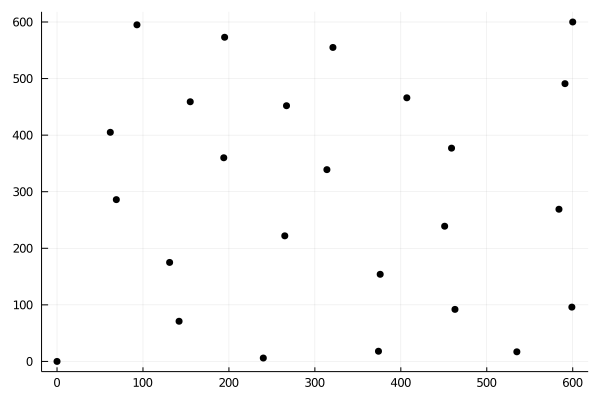

In [7]:
scatter(Coord[:,2], Coord[:,1], legend=false, c="black")

Calcula a matriz de distâncias

In [8]:
Distancias = [dist_euclid(Coord[i,1], Coord[i,2], Coord[j,1], Coord[j,2]) 
    for i in 1:np, j in 1:np];

Ordenar distâncias, atribuir adjacências para as 3 menos, atribuir as alturas e demandas das arestas com adjacências

In [9]:
MenDist = fill(0.0, (np, 3))
for i = 1:np
    vet_temp = sort(Distancias[i,:])
    MenDist[i,1:3] = vet_temp[2:4]
end

In [10]:
Adjacencias = fill(0, (np, np))
#Altura = fill(0, (np, np))
Demanda = fill(0, (np, np))
for i in 1:np
    for j in i:np
        if i != j
            if Distancias[i,j]>MenDist[i,3]
                Distancias[i,j] = 1e4
                Distancias[j,i] = 1e4
            else
                Adjacencias[i,j] = 1
                Adjacencias[j,i] = 1
                #Altura[i,j] = rand(-2:2)
                #Altura[j,i] = -Altura[i,j]
                Demanda[i,j] = rand(50:100)
                Demanda[j,i] = Demanda[i,j]
            end
        end
    end
end

Imprime o gráfico das adjacências, as cores representam os desníveis das arestas, na direção da aresta i->j.
### Mudar para altura no ponto, não na aresta.

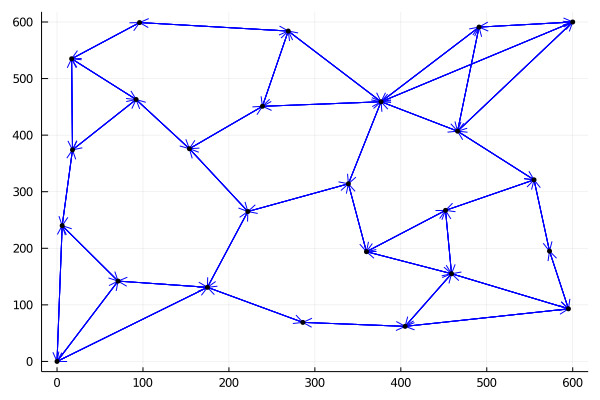

In [11]:
pl1=plot()
#=for i = 1:np, j = 1:np
        if Adjacencias[i,j] == 1
            if Altura[i,j] == -2
                cc=:red
            elseif Altura[i,j] == -1
                cc=:orange
            elseif Altura[i,j] == 0 
                cc=:yellow
            elseif Altura[i,j] == 1
                cc=:green
            else
                cc=:blue
            end    

            plot!(pl1, [Coord[i,1], Coord[j,1]], [Coord[i,2], Coord[j,2]], 
                  c=cc, l=:arrow)
        end 
end
scatter!(pl1, Coord[:,1], Coord[:,2], c="black", leg = false, ms = 3)=#

for i = 1:np, j = 1:np
        if Adjacencias[i,j] == 1
            plot!(pl1, [Coord[i,1], Coord[j,1]], [Coord[i,2], Coord[j,2]], c=:blue, 
                  l=:arrow)
        end 
end
scatter!(pl1, Coord[:,1], Coord[:,2], c="black", leg = false, ms = 3)

### Modelo do carteiro chinês - básico

\begin{align}
\text{Min } & Z = \sum_{i=1}^{n} \sum_{j=1}^{n} \sum_{p \in S}
C_{i,j}^p x_{i,j}^p \\
\text{sujeito à} \hspace{0.6cm} & \sum_{k=1}^{n} x_{i,k}^p = \sum_{k=1}^{n} x_{k,i}^p \hspace{0.4cm} i=1,...,n; p \in S \\
& \sum_{p=1}^S (l_{i,j}^p + l_{j,i}^p) = \lceil\frac{q_{i,j}}{w}\rceil \hspace{0.4cm} \forall (i,j) \in A\\
& x_{i,j}^p \geq l_{i,j}^p  \hspace{0.4cm} \forall  (i,j) \in A, p \in S\\
& \sum_{i=1}^{n} \sum_{j=1}^{n} l_{i,j}^p q_{i,j} \leq w \hspace{0.4cm} p \in S\\
& \sum_{k=1}^n f_{i,k}^p - \sum_{k=1}^n f_{k,i}^p = \sum_{j=1}^n l_{i,j}^p \hspace{0.4cm} \forall i \in A| \{1\}, p \in S\\  
& f_{i,j}^p \leq (n^2) x_{i,j}^p, \hspace{0.4cm} \forall (i,j) \in A, p \in S\\
& f_{i,j}^p \geq 0 \hspace{0.4cm} \forall (i,j) \in A, p \in S\\
& l_{i,j}^p, x_{i,j}^p \in \mathbf{Z}^+ \hspace{0.4cm} \forall (i,j) \in A, p \in S
\end{align}


In [12]:
# Usando os dados criados
C = Distancias
q = Demanda
adja = Adjacencias
W = 1200 # espera-se 3 caminhões
nIJ = np #número de pontos
nP = 3 #número máximo de veículos

3

In [13]:
sum(q)/2

3137.0

In [14]:
using JuMP, Gurobi

In [15]:
#Gurobi
model = Model(Gurobi.Optimizer)
JuMP.set_optimizer_attribute(model, "TimeLimit", 180)
JuMP.set_optimizer_attribute(model, "MIPFocus", 1)

@variable(model, x[i=1:nIJ, j=1:nIJ, p=1:nP] ≥ 0, Int) 
@variable(model, l[i=1:nIJ, j=1:nIJ, p=1:nP] ≥ 0, Int) 
@variable(model, f[i=1:nIJ, j=1:nIJ, p=1:nP] ≥ 0)
length(all_variables(model))

Academic license - for non-commercial use only


5625

In [16]:
@objective(model, Min,
             sum(x[i,j,p] * C[i,j] for i=1:nIJ, j=1:nIJ, p=1:nP)); 

@constraint(model, fluxo[i=1:nIJ,p=1:nP], 
            sum(x[i,k,p] for k=1:nIJ) == sum(x[k,i,p] for k=1:nIJ))
@constraint(model, arc_atend[i=1:nIJ,j=1:nIJ],
            sum(l[i,j,p] + l[j,i,p] for p=1:nP) == (adja[i,j]))
@constraint(model, pass_demanda[i=1:nIJ,j=1:nIJ, p=1:nP],
            x[i,j,p] >= l[i,j,p])
@constraint(model, capac[p=1:nP],
            sum(l[i,j,p]*q[i,j] for i=1:nIJ, j=1:nIJ) <= W)
@constraint(model, contr_fluxo[i=2:nIJ,p=1:nP],
            sum(f[i,k,p] for k=1:nIJ) - sum(f[k,i,p] for k=1:nIJ) == 
            sum(l[i,j,p] for j=1:nIJ))
@constraint(model, contr_fluxo2[i=1:nIJ, j=1:nIJ ,p=1:nP],
            f[i,j,p] <= (np)^2*x[i,j,p]);

In [17]:
optimize!(model)
#length(all_variables(model))

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (linux64)
Optimize a model with 4525 rows, 5625 columns and 20265 nonzeros
Model fingerprint: 0xc1d90987
Variable types: 1875 continuous, 3750 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [1e+02, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 1419698.4256
Presolve removed 2302 rows and 1791 columns
Presolve time: 0.03s
Presolved: 2223 rows, 3834 columns, 11817 nonzeros
Variable types: 1800 continuous, 2034 integer (234 binary)

Root relaxation: objective 5.535847e+03, 1709 iterations, 0.14 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5535.84741    0  154 1419698.43 5535.84741   100%     -    0s
H    0     0                    468357.61588 5535.84741  98.8%     -    0s
H    0     0                    9

Verificando a solução:
$ l * q $ representa a demanda coletada por cada caminhão

In [18]:
sum(value.(l[:,:,:]).*q[:,:])

3137.0

Demanda total que deveria ser coletada

In [19]:
sum(q)/2

3137.0

In [20]:
objective_value(model), termination_status(model), primal_status(model), dual_status(model)

(7610.461596902387, MathOptInterface.TIME_LIMIT, MathOptInterface.FEASIBLE_POINT, MathOptInterface.NO_SOLUTION)

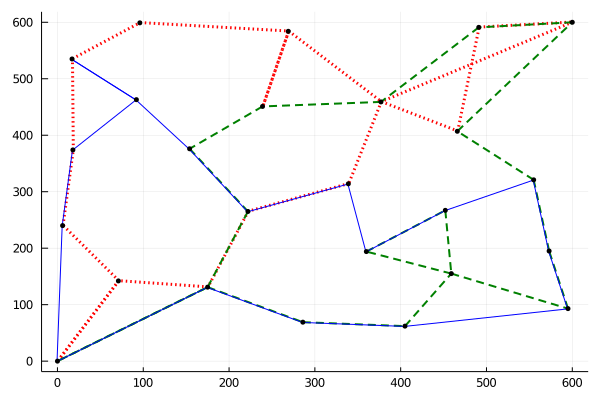

In [21]:
x = round.(Int, value.(x))
pl2=plot()
p = 1
for i = 1:nIJ, j = 1:nIJ
    if (x[i,j,p] > 0)
        pl2=plot!([Coord[i,1]+0.5, Coord[j,1]+0.5], 
                  [Coord[i,2]+0.5, Coord[j,2]+0.5], 
                  ls =:dot, c=:red, lw = 3, lab="")
    end
end
p=2
for i = 1:nIJ, j = 1:nIJ
    if (x[i,j,p] > 0)
        pl2=plot!([Coord[i,1], Coord[j,1]], 
                  [Coord[i,2], Coord[j,2]], 
                  ls =:dash, lw=2, c=:green, lab="")
    end
end
p=3
for i = 1:nIJ, j = 1:nIJ
    if (x[i,j,p] > 0)
        pl2=plot!([Coord[i,1]-0.5, Coord[j,1]-0.5], 
                  [Coord[i,2]-0.5, Coord[j,2]-0.5], c=:blue, lab="")
    end
end
pl2=scatter!(Coord[:,1], Coord[:,2], c="black", leg = false, ms = 3)
pl2

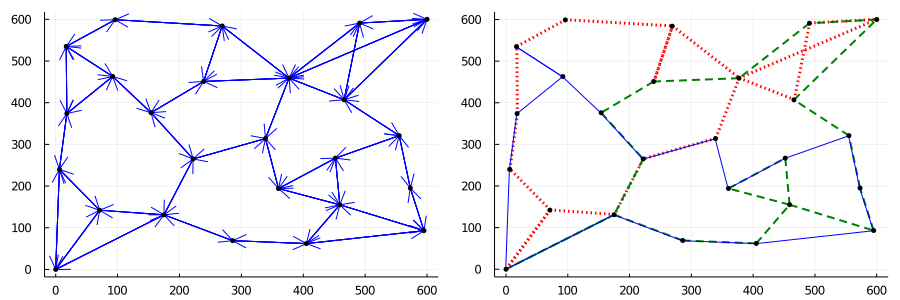

In [22]:
plot(pl1, pl2, size=(900,300))

Obtendo a resposta:
Para cada veículo, obter os nós que foram visitados.

In [23]:
k1, k2, k3 = 1, 1, 1
Caminhao1 = fill(0, sum(x[:,:,1]) ,2)
Caminhao2 = fill(0, sum(x[:,:,2]) ,2)
Caminhao3 = fill(0, sum(x[:,:,3]) ,2)

for i = 1:nIJ, j=1:nIJ
    if x[i,j,1] == 1 
        Caminhao1[k1,1], Caminhao1[k1,2] = i, j
        k1+=1
        if x[i,j,1] == 2 
            Caminhao1[k1,1], Caminhao1[k1,2] = i, j
            Caminhao1[k1+1,1], Caminhao1[k1+1,2] = i, j
            k1+=2
        end
    end
    if x[i,j,2] == 1
        Caminhao2[k2,1], Caminhao2[k2,2] = i, j
        k2+=1
        if x[i,j,2] == 2 
            Caminhao2[k2,1], Caminhao2[k2,2] = i, j
            Caminhao2[k2+1,1], Caminhao2[k2+1,2] = i, j
            k2+=2
        end
    end
    if x[i,j,3] == 1
        Caminhao3[k3,1], Caminhao3[k3,2] = i, j
        k3+=1
        if x[i,j,3] == 2 
            Caminhao3[k3,1], Caminhao3[k3,2] = i, j
            Caminhao3[k3+1,1], Caminhao3[k3+1,2] = i, j
            k3+=2
        end
    end
end



In [24]:
Caminhao1
#Caminhao1 = Caminhao1[1:end-2,:]

18×2 Array{Int64,2}:
  1  15
  2  14
  3  15
  5  10
  9   2
 10   5
 10  14
 11  25
 13  19
 14  16
 14  17
 15   1
 15  11
 16   9
 17  24
 19  10
 24   3
 25  13

In [25]:
Caminhao2
#Caminhao2 = Caminhao2[1:end-2,:]

19×2 Array{Int64,2}:
  1   3
  2   9
  3   1
  3  23
  4   7
  5   8
  6  21
  7  20
  8  24
  9  14
 12  20
 14   5
 16   2
 20   4
 20   6
 21  22
 22  16
 23  12
 24   3

In [26]:
Caminhao3

17×2 Array{Int64,2}:
  1  11
  3   1
  4   7
  6  12
  7  22
  8  24
 11  25
 12  23
 13  18
 17   4
 18   8
 18  13
 21   6
 22  21
 23   3
 24  17
 25  18

Obter uma rota válida em sequência

In [27]:
function OrdenaPath(MatrizNos)

    CamOrd = [fill(0, length(MatrizNos[:,1]),1) MatrizNos]
    CamOrd[1,1] = 1
    OrigTemp = CamOrd[1,3]
    Iter = 1
    while Iter < length(CamOrd[:,1])
        IterPre = Iter
        for i = 2:length(CamOrd[:,1])
            if CamOrd[i,1] == 0 && CamOrd[i,2] == OrigTemp 
                CamOrd[i,1] = Iter + 1
                OrigTemp = CamOrd[i,3]
                Iter +=1
                break
            end
        end
             
        if Iter == IterPre
            println("Deu Ruim, vamos trocar!")
            #inverter a prioridade de um subtrajeto
            for i = 2:length(CamOrd[:,1]), j = 2:length(CamOrd[:,1])
                if CamOrd[i,2] == CamOrd[j,2] && CamOrd[i,1] == 0 && CamOrd[j,1] != 0
                    DestTemp = CamOrd[i,3]
                    CamOrd[i,3] = CamOrd[j,3]
                    CamOrd[j,3] = DestTemp
                    CamOrd = OrdenaPath(CamOrd[:,2:3])
                    return CamOrd
                end
            end
        end
    end

return CamOrd
end

OrdenaPath (generic function with 1 method)

In [28]:
CamOrd1 = sortslices(OrdenaPath(Caminhao1), dims=1)
CamOrd2 = sortslices(OrdenaPath(Caminhao2), dims=1)
CamOrd3 = sortslices(OrdenaPath(Caminhao3), dims=1)


Deu Ruim, vamos trocar!
Deu Ruim, vamos trocar!
Deu Ruim, vamos trocar!


17×3 Array{Int64,2}:
  1   1  11
  2  11  25
  3  25  18
  4  18  13
  5  13  18
  6  18   8
  7   8  24
  8  24  17
  9  17   4
 10   4   7
 11   7  22
 12  22  21
 13  21   6
 14   6  12
 15  12  23
 16  23   3
 17   3   1

## Mostra as soluções

In [29]:
using Plots
gr(size = (640, 480))

Plots.GRBackend()

In [30]:
using Interact   

@manipulate for frame1 = 1:CamOrd1[end,1]
    
    p=scatter(Coord[:,1], Coord[:,2], c="black", leg = false, ms = 3)
    xlims!(0,largArea)
    ylims!(0,largArea)
    
    for k0 = 1:frame1
        i1 = CamOrd1[k0, 2]
        j1 = CamOrd1[k0, 3]
        p=plot!([Coord[i1,1], Coord[j1,1]], [Coord[i1,2], Coord[j1,2]], 
            lw = 1, c=:blue, lab="")
    end    
    p
end

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-8466464610804635632\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-17551033318940049517\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-8466464610804635632\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["frame1"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 18,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
9, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/home/franklin/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/franklin/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/franklin/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/home/franklin/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/home/franklin/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f71e817ceb0, Task (runnable) @0x00007f71e817ceb0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"1994110943650750132\",\"id\":\"17406706587793568361\",\"t

In [31]:
using Interact   

@manipulate for frame1 = 1:CamOrd1[end,1], 
                frame2 = 1:CamOrd2[end,1], 
                frame3 = 1:CamOrd3[end,1]
    
    p=scatter(Coord[:,1], Coord[:,2], c="black", leg = false, ms = 3)
    xlims!(0,largArea)
    ylims!(0,largArea)
    
    for k0 = 1:frame1
        i1 = CamOrd1[k0, 2]
        j1 = CamOrd1[k0, 3]
        p=plot!([Coord[i1,1], Coord[j1,1]], [Coord[i1,2], Coord[j1,2]], 
            lw = 1, c=:blue, lab="")
    end
    
    for k0 = 1:frame2
        i2 = CamOrd2[k0, 2]
        j2 = CamOrd2[k0, 3]
        p=plot!([Coord[i2,1], Coord[j2,1]], [Coord[i2,2], Coord[j2,2]], 
            lw = 2, ls =:dot, c=:red, lab="")
    end
    
    for k0 = 1:frame3
        i3 = CamOrd3[k0, 2]
        j3 = CamOrd3[k0, 3]
        p=plot!([Coord[i3,1], Coord[j3,1]], [Coord[i3,2], Coord[j3,2]], 
            lw = 2, ls=:dash, c=:green, lab="")
    end
    
    p
end


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["frame1"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 18,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
9, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/home/franklin/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/franklin/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/franklin/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/home/franklin/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/home/franklin/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f71f6827820, Task (runnable) @0x00007f71f6827820), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"751680765788341933\",\"id\":\"11807549968444718785\",\"ty

Melhorias - Usar uma heurística para obter uma solução inicial...

E então tentar com mais pontos, por mais tempo.